In [1]:
import corner
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root

In [2]:
# True parameters for two-parametric total least squares
n_vars = 2
true_slope_1 = 0.6
true_slope_2 = -0.8
assert abs(true_slope_1**2 + true_slope_2**2 - 1) < 1e-8
true_intercept = 0.5
true_dispersion = 0.3
observation_uncertainty_scale = 0.2

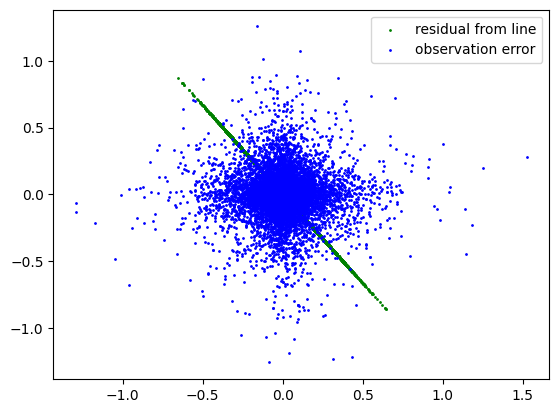

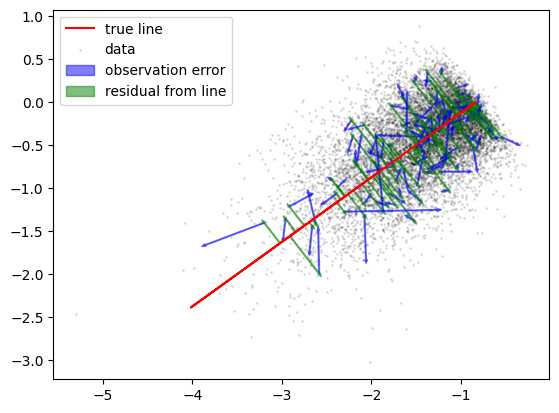

In [3]:
# Generate data for two-parametric total least squares
num_points = 10_000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
sample_key = jax.random.split(subkey, 1); del subkey
data_residuals = jax.random.normal(sample_key, [num_points]) * true_dispersion; del sample_key

# t can be anything, but we'll use the half normal distribution
key, subkey = jax.random.split(key)
sample_key = jax.random.split(subkey, 1); del subkey
true_t = tfd.HalfNormal(scale=1.0).sample(seed=sample_key, sample_shape=(num_points,)); del sample_key

# jnp.hypot is 1 (see assert above), but we do it just to be explicit
true_x_1 = -true_intercept / true_slope_1 + true_t * true_slope_2 / jnp.hypot(true_slope_1, true_slope_2)
true_x_2 = (-true_intercept - true_slope_1 * true_x_1) / true_slope_2

# x-uncertainties can be anything, but we'll use the exponential distribution.
# We also change the uncertainties scale over the line
key, subkey = jax.random.split(key)
sample_key1, sample_key2 = jax.random.split(subkey, 2); del subkey
data_sigma_sq1 = jnp.clip(true_t, 0.1, 10.0) * observation_uncertainty_scale**2 * jax.random.exponential(sample_key1, (num_points,)); del sample_key1
data_sigma_sq2 = jnp.clip(true_t, 0.1, 10.0) * observation_uncertainty_scale**2 * jax.random.exponential(sample_key2, (num_points,)); del sample_key2
data_sigma2 = jnp.stack([data_sigma_sq1, data_sigma_sq2], axis=-1)

key, subkey = jax.random.split(key)
sample_key1, sample_key2 = jax.random.split(subkey, 2); del subkey
data_dx1 = jax.random.normal(sample_key1, (num_points,)) * jnp.sqrt(data_sigma_sq1); del sample_key1
data_dx2 = jax.random.normal(sample_key2, (num_points,)) * jnp.sqrt(data_sigma_sq2); del sample_key2

true_line = jnp.stack([true_x_1, true_x_2], axis=-1)
residual_from_line = jnp.stack([true_slope_1, true_slope_2], axis=-1) * data_residuals[:, None]
observation_error = jnp.stack([data_dx1, data_dx2], axis=-1)

plt.figure()
plt.scatter(*residual_from_line.T, s=1, color='g', label='residual from line')
plt.scatter(*observation_error.T, s=1, color='b', label='observation error')
plt.legend()

data_x = (true_line + residual_from_line + observation_error)

plt.figure()
plt.plot(*true_line.T, 'r-', label='true line')
plt.scatter(*data_x.T, color='k', s=1, alpha=0.1, label='data')
for i, x, y, dx, dy, rx, ry in zip(np.arange(100), *data_x.T, *observation_error.T, *residual_from_line.T):
    plt.arrow(x-dx, y-dy, dx, dy, color='b', alpha=0.5, width=0.01, label='observation error' if i == 0 else None)
    plt.arrow(x-dx-rx, y-dy-ry, rx, ry, color='g', alpha=0.5, width=0.01, label='residual from line' if i == 0 else None)
plt.legend()

CPU times: user 40.6 s, sys: 12.2 s, total: 52.8 s
Wall time: 36.7 s


ChainStats(mean=array([0.7686474 , 0.51048297, 0.299055  ], dtype=float32), median=array([0.76869756, 0.51057863, 0.29903388], dtype=float32), variance=array([1.2967559e-04, 1.0645074e-04, 7.0006831e-06], dtype=float32), standard_error=array([2.6686897e-04, 2.4194732e-04, 2.6924843e-05], dtype=float32), effective_sample_size=array([1820.7996, 1818.4738, 9656.818 ], dtype=float32), rhat=array(910.907, dtype=float32), percentiles=array([[0.74303246, 0.4864084 , 0.29301515],
       [0.7454835 , 0.48917076, 0.2936611 ],
       [0.7470453 , 0.4906888 , 0.29406297],
       [0.74840796, 0.49218273, 0.29441512],
       [0.74953365, 0.4932296 , 0.29472443],
       [0.7504201 , 0.4941895 , 0.29495212],
       [0.75138885, 0.4949375 , 0.29514825],
       [0.75223833, 0.49567997, 0.29536387],
       [0.7530741 , 0.49634337, 0.29552025],
       [0.7538179 , 0.49700066, 0.29569057],
       [0.754437  , 0.49766004, 0.29581895],
       [0.75500405, 0.49820575, 0.29596558],
       [0.75559413, 0.498738

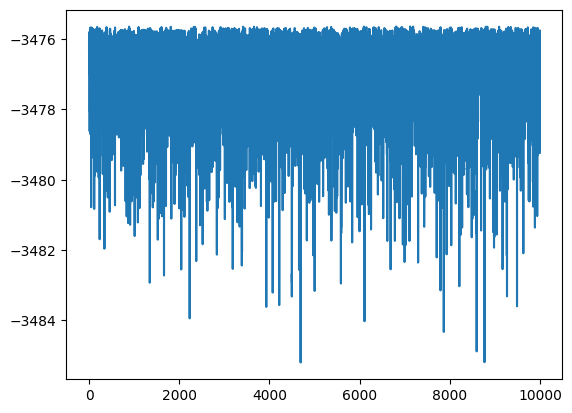

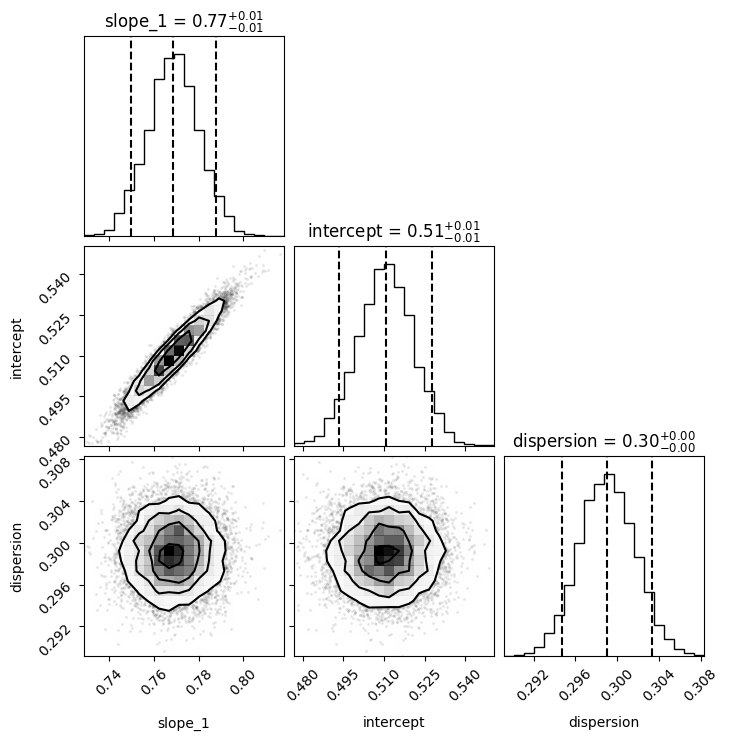

In [4]:
%%time

from calibration.least_squares import least_squares, ChainStats

states, log_probs = least_squares(
    # x=data_x,
    # type='total',
    # sigma2=data_sigma2,
    x=data_x,
    type='ordinal',
    sigma2=data_sigma2,
    num_samples=10_000,
    nuts_kwargs=dict(step_size=1e-3),
)

plt.figure()
plt.plot(log_probs)

corner.corner(
    data=np.asarray(states),
    labels=['slope_1', 'intercept', 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
)

ChainStats.from_states(states)